# AIPI 590 - XAI | Mechanistic Interpretability Assignment
## Greater-Than Comparison Task: Explaining a Tiny Brain
### Peter Banyas

**Task:** Build a tiny transformer that learns to compare two numbers, then reverse-engineer how it makes decisions.

Built in partnership with Claude Code!

#### Open in Google Colab:
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/banyasp/hw7_mechanistic_interpretability/blob/main/main.ipynb)

In [ ]:
# Code from Prof. Brinnae Bent's GitHub.
# Setup for Google Colab (skip if running locally)
import os

# Remove Colab default sample_data if it exists
if os.path.exists('./sample_data'):
    !rm -r ./sample_data

# Clone your GitHub repository
repo_name = "hw7_mechanistic_interpretability"  # Change to your repo name
git_path = 'https://github.com/banyasp/hw7_mechanistic_interpretability/blob/main/main.ipynb'  # Change to your repo URL

# Uncomment these lines when running in Colab:
# !git clone "{git_path}"
# %cd "{repo_name}"
# %ls

print("Setup complete!")

Setup complete!


# Mechanistic Interpretability: Greater-Than Comparison Task

In this notebook, I'm building a tiny transformer that learns to compare two numbers, then peek inside to understand **how** it makes decisions.

**Task:** Given `[num1, num2]`, predict which is larger
- Label 0: First number is greater
- Label 1: Second number is greater  
- Label 2: Numbers are equal

**Goals:**
- Discover what attention patterns emerge
- Identify which heads specialize in comparison
- Reverse-engineer the "greater-than circuit"

## Setup: Imports and Configuration

In [25]:
# Built with Claude Code, Nov 10 2025
# Import all necessary libraries and functions from greater_than_model.py
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import our custom functions and classes
from greater_than_model import (
    generate_comparison_data,
    create_train_val_split,
    GreaterThanTransformer,
    train_model,
    plot_training_curves,
    visualize_attention_patterns,
    analyze_head_behavior,
    ablate_head,
    inspect_qk_circuit,
    test_hypothesis
)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Determine device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

Using device: cpu


## Step 1: Generate Data

Creating a dataset of number pairs and their comparison labels.

In [ ]:
# Built with Claude Code, Nov 10 2025
# Generate comparison dataset
dataset = generate_comparison_data(
    num_samples=2000,
    num_range=(0, 20),
    include_equal=True
)

# Split into train and validation sets
train_dataset, val_dataset = create_train_val_split(dataset, val_fraction=0.2)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"\nExample inputs: {train_dataset.inputs[:5]}")
print(f"Example labels: {train_dataset.labels[:5]}")
print(f"\nLabel meanings: 0=first greater, 1=second greater, 2=equal")

Train samples: 1600
Val samples: 400

Example inputs: tensor([[ 9, 15],
        [18,  0],
        [ 8,  2],
        [ 4,  2],
        [19, 17]])
Example labels: tensor([1, 0, 0, 0, 0])

Label meanings: 0=first greater, 1=second greater, 2=equal


## Step 2: Create and Train Model

We'll build a tiny transformer with:
- 2 layers
- 4 attention heads per layer
- Attention-only architecture (no MLPs for easier interpretation)

In [ ]:
# Built with Claude Code, Nov 10 2025
# Create the model
model = GreaterThanTransformer(
    vocab_size=25,      # Support numbers 0-24
    d_model=64,         # Embedding dimension
    n_heads=4,          # 4 attention heads per layer
    n_layers=2,         # 2 transformer layers
    n_classes=3         # 3 output classes
)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
print(f"Model Architecture:")
print(f"  - Embedding dimension: 64")
print(f"  - Layers: 2")
print(f"  - Heads per layer: 4")
print(f"  - Total parameters: {total_params:,}")
print(f"\nThis tiny model trains in ~5 minutes on CPU!")

Model Architecture:
  - Embedding dimension: 64
  - Layers: 2
  - Heads per layer: 4
  - Total parameters: 35,075

This tiny model trains in ~5 minutes on CPU!


In [ ]:
# Built with Claude Code, Nov 10 2025
# Train the model
print("Training model...\n")
history = train_model(
    model,
    train_dataset,
    val_dataset,
    n_epochs=100,
    batch_size=32,
    learning_rate=1e-3,
    device=device,
    verbose=True
)

print("\nTraining complete!")

Training model...

Epoch   0/100 | Train Loss: 0.6686 | Train Acc: 0.7200 | Val Loss: 0.2444 | Val Acc: 0.9300 | Time: 0.4s
Epoch  10/100 | Train Loss: 0.0013 | Train Acc: 1.0000 | Val Loss: 0.0011 | Val Acc: 1.0000 | Time: 2.4s
Epoch  20/100 | Train Loss: 0.0004 | Train Acc: 1.0000 | Val Loss: 0.0003 | Val Acc: 1.0000 | Time: 4.9s
Epoch  30/100 | Train Loss: 0.0002 | Train Acc: 1.0000 | Val Loss: 0.0002 | Val Acc: 1.0000 | Time: 7.1s
Epoch  40/100 | Train Loss: 0.0001 | Train Acc: 1.0000 | Val Loss: 0.0001 | Val Acc: 1.0000 | Time: 9.4s
Epoch  50/100 | Train Loss: 0.0001 | Train Acc: 1.0000 | Val Loss: 0.0001 | Val Acc: 1.0000 | Time: 11.6s
Epoch  60/100 | Train Loss: 0.0000 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000 | Time: 13.7s
Epoch  70/100 | Train Loss: 0.0000 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000 | Time: 15.8s
Epoch  80/100 | Train Loss: 0.0000 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000 | Time: 17.8s
Epoch  90/100 | Train Loss: 0.00

## Step 3: Visualize Training Dynamics

Let's see how the model learned over time.

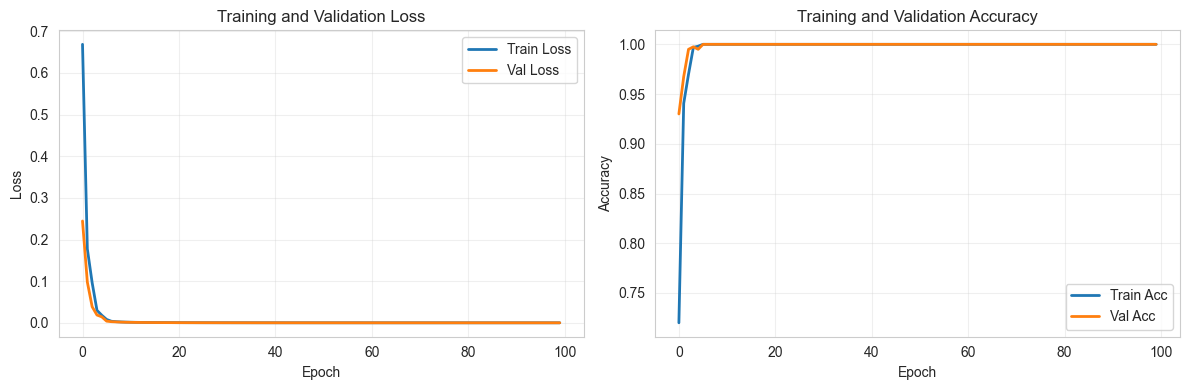

Final training accuracy: 1.0000
Final validation accuracy: 1.0000


In [ ]:
# Built with Claude Code, Nov 10 2025
# Plot training curves
fig = plot_training_curves(history)
plt.show()

print(f"Final training accuracy: {history['train_acc'][-1]:.4f}")
print(f"Final validation accuracy: {history['val_acc'][-1]:.4f}")

## Step 4: Explore Attention Patterns

**This is where the magic happens!**

Let's visualize what each attention head is looking at. We'll test with interesting cases:
- Large differences (15 vs 3)
- Small differences (12 vs 11)  
- Equal numbers (10 vs 10)

In [ ]:
# Started with Claude Code, Nov 10 2025, extended by me.
# Define interesting test cases
test_inputs = torch.tensor([
    [15, 3],   # First much greater
    [20, 1],
    [17,9],
    [15,12],
    [2, 18],   # Second much greater
    [4,22],
    [6,17],
    [3,8],
    [10, 10],  # Equal
    [1, 1],
    [19, 19],
    [13,13],
    [11,11],
    [12, 11],  # First slightly greater
    [19, 18],
    [4,2],
    [14, 16],    # Second slightly greater
    [1,2],
    [11,13],
])

print("Test cases:")
for i, (num1, num2) in enumerate(test_inputs):
    comparison = ">" if num1 > num2 else ("<" if num1 < num2 else "=")
    print(f"  {i+1}. [{num1.item():2d}, {num2.item():2d}] → {num1.item()} {comparison} {num2.item()}")

Test cases:
  1. [15,  3] → 15 > 3
  2. [20,  1] → 20 > 1
  3. [17,  9] → 17 > 9
  4. [15, 12] → 15 > 12
  5. [ 2, 18] → 2 < 18
  6. [ 4, 22] → 4 < 22
  7. [ 6, 17] → 6 < 17
  8. [ 3,  8] → 3 < 8
  9. [10, 10] → 10 = 10
  10. [ 1,  1] → 1 = 1
  11. [19, 19] → 19 = 19
  12. [13, 13] → 13 = 13
  13. [11, 11] → 11 = 11
  14. [12, 11] → 12 > 11
  15. [19, 18] → 19 > 18
  16. [ 4,  2] → 4 > 2
  17. [14, 16] → 14 < 16
  18. [ 1,  2] → 1 < 2
  19. [11, 13] → 11 < 13


### Layer 0 Attention Patterns

Each heatmap shows where tokens attend to each other:
- **Rows:** Source position (what's attending)
- **Columns:** Target position (what's being attended to)
- **Values:** Attention weights (0 to 1)


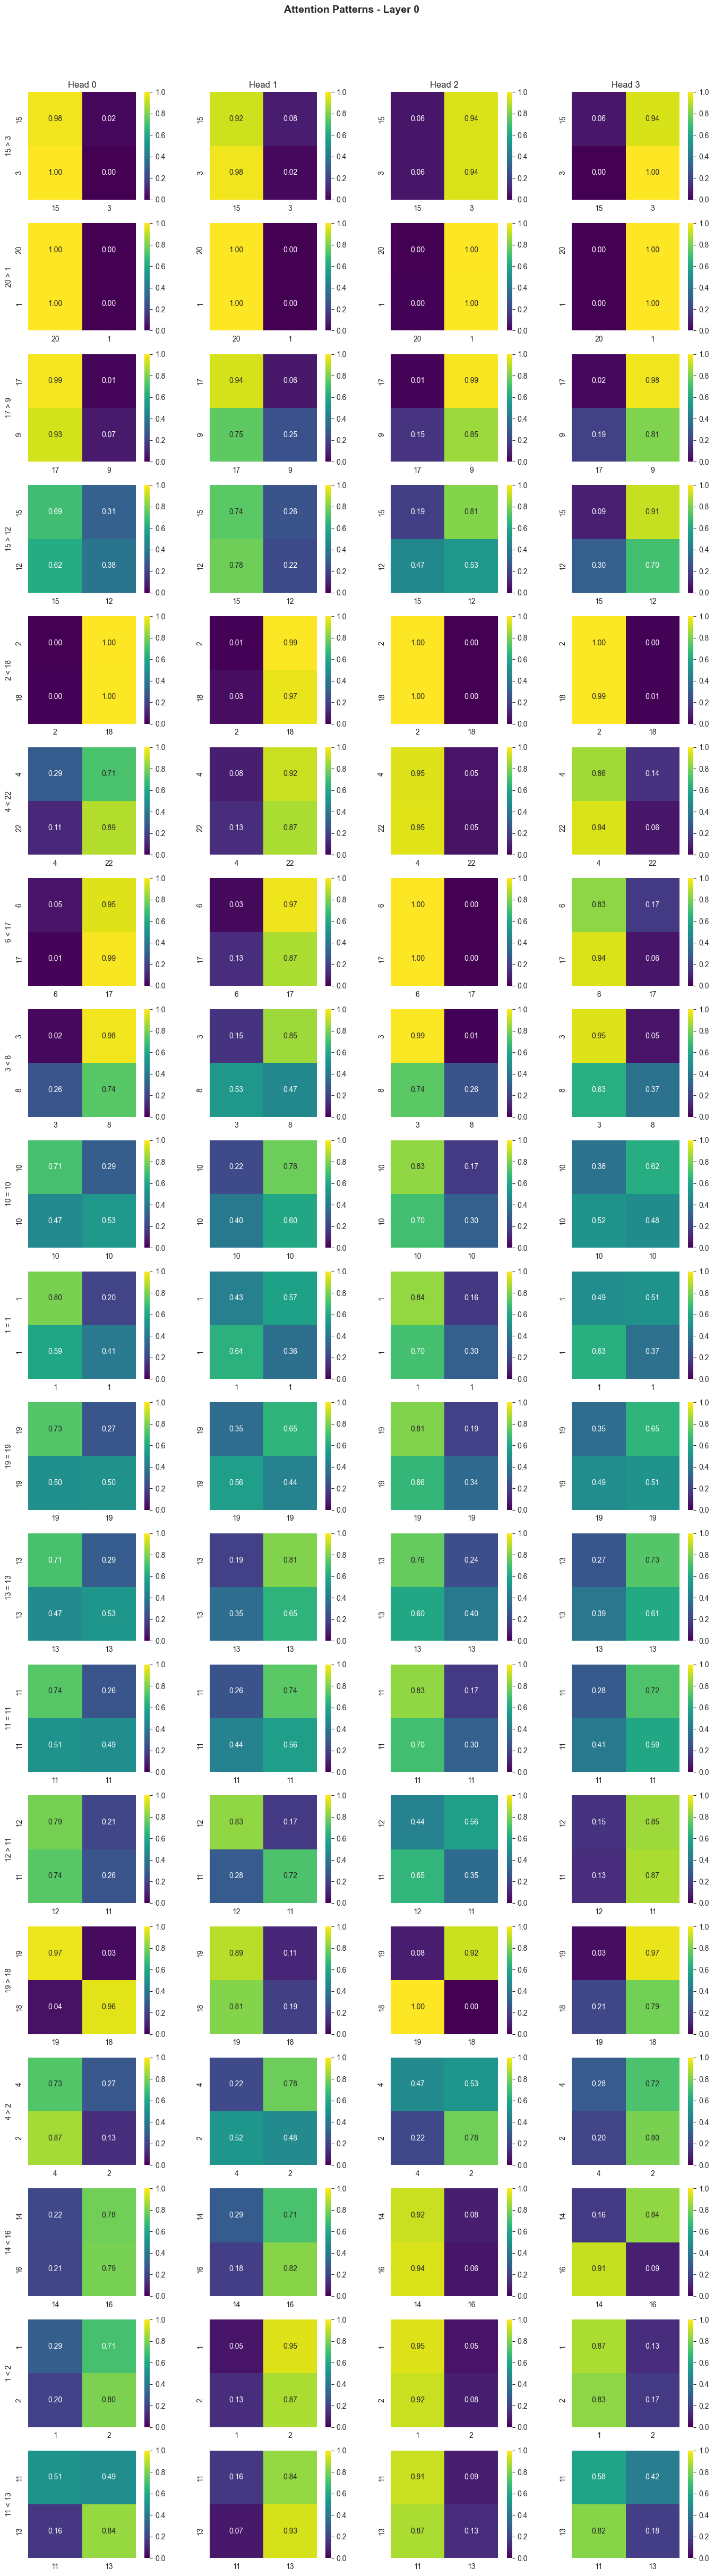

In [ ]:
# Built in conversation with Claude Code, Nov 10 2025
# Visualize Layer 0 attention patterns
fig = visualize_attention_patterns(model, test_inputs, layer_idx=0, device=device)
plt.show()

## **Commentary on Layer 0**

### Head 0 & Head 3
These heads appear to be relatively symmetric, with Head 0 capturing clearly bigger numbers and Head 3 capturing clearly smaller numbers. This is largely token-invariant, at least in cases where there is a dramatic difference in the magnitude of the two tokens.  These attention heads are effectively a channel, pulling the big numbers forward to the next layer with disregard for the other token. 

It's interesting how these heads attend to the same big-number or small-number-dominant token, regardless of which token is doing the attending.  This shows that it is more focused on capgturing that big or small number than it is with doing anything conditionally dependent on the other token.    

Of course, this system isn't always behaving that way, especially in cases when the numbers are closer together.

### Head 1 & Head 2
These hands seem to be helping, especially in cases where the values are close to each other. When that's the case, Head 2 is generally more dominant on choosing the smaller number to attend to, irrespective of which token is doing the attending.  Head 1 is a little bit reflexive compared to head 2 and tries to bias towards the bigger number, but it shines more in cases where they are close.

Collectively, these four heads seem to distribute the expertise of what to look for. Where some heads are looking for really big differences, and some are looking for smaller differences. And then some of them are more involved in the bigger number, while others are involved in the smaller. Spread across four different heads, that gives the perfect amount of flexibility to capture all that information.


### Layer 1 Attention Patterns

The second layer can build on patterns from the first layer.

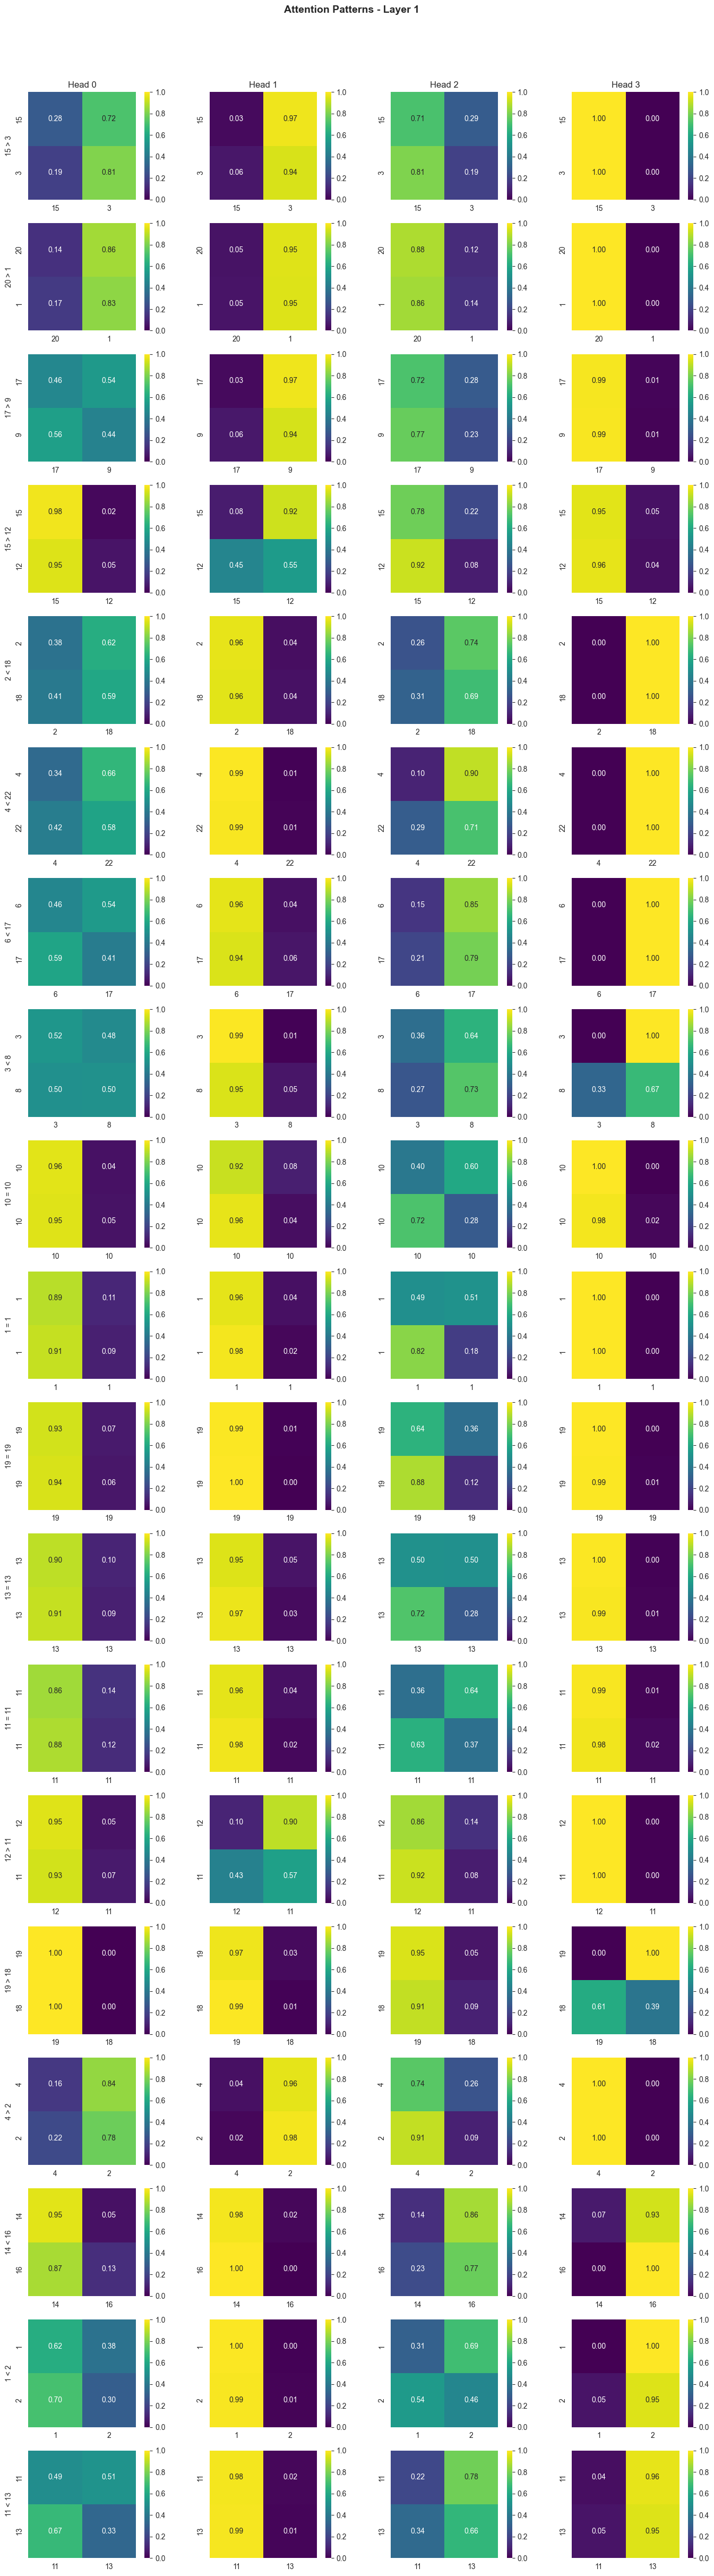

In [ ]:
# Built in conversation with Claude Code, Nov 10 2025
# Visualize Layer 1 attention patterns
fig = visualize_attention_patterns(model, test_inputs, layer_idx=1, device=device)
plt.show()

### Head 1 & Head 3
Unlike in layer one, here we see a lot more similarities between head one and three rather than zero and three. We can see that heads one and three are a lot more strong and dominant towards capturing the smaller or the larger of the tokens as the token that it's attending to. These heads act that way largely irrespective of the token that is doing the attending.

### Head 0 & Head 2
Here, the attention matrices are a lot more mixed, where it is actually blending the influence of each token and varying that depending on which token is doing the attending. Therefore, that's likely a lot more complex logic involving the comparison, whereas Heads 1 and 3 were largely just looking at big indicators that maybe were already captured.

## Step 5: Ablation Studies

**Question:** Which heads are crucial for the task?

We'll "remove" each head and measure the drop in accuracy. If accuracy drops significantly, that head is important!

In [ ]:
# Built with Claude Code, Nov 10 2025
# Get baseline accuracy
model.eval()
with torch.no_grad():
    logits = model(val_dataset.inputs.to(device))
    predictions = torch.argmax(logits, dim=-1)
    baseline_acc = (predictions == val_dataset.labels.to(device)).float().mean().item()

print("=" * 70)
print("ABLATION STUDY: Testing Head Importance")
print("=" * 70)
print(f"\nBaseline accuracy (all heads active): {baseline_acc:.4f}")
print("\nAccuracy after removing each head:\n")

# Test each head
ablation_results = []
for layer_idx in range(2):
    for head_idx in range(4):
        ablated_acc = ablate_head(
            model,
            val_dataset,
            layer_idx=layer_idx,
            head_idx=head_idx,
            device=device
        )
        drop = baseline_acc - ablated_acc
        ablation_results.append({
            'layer': layer_idx,
            'head': head_idx,
            'accuracy': ablated_acc,
            'drop': drop
        })

        # Visual indicator of importance
        importance = "CRITICAL" if drop > 0.05 else ("MODERATE" if drop > 0.02 else "LOW")
        print(f"  Layer {layer_idx}, Head {head_idx}: {ablated_acc:.4f} (drop: {drop:+.4f}) {importance}")

# Identify most important heads
ablation_results.sort(key=lambda x: x['drop'], reverse=True)
print(f"\n{'='*70}")
print("Most important heads (by accuracy drop):")
for i, result in enumerate(ablation_results[:3]):
    print(f"  {i+1}. Layer {result['layer']}, Head {result['head']}: {result['drop']:+.4f} drop")

ABLATION STUDY: Testing Head Importance

Baseline accuracy (all heads active): 1.0000

Accuracy after removing each head:

  Layer 0, Head 0: 0.9800 (drop: +0.0200) LOW
  Layer 0, Head 1: 1.0000 (drop: +0.0000) LOW
  Layer 0, Head 2: 0.9850 (drop: +0.0150) LOW
  Layer 0, Head 3: 0.9925 (drop: +0.0075) LOW
  Layer 1, Head 0: 1.0000 (drop: +0.0000) LOW
  Layer 1, Head 1: 1.0000 (drop: +0.0000) LOW
  Layer 1, Head 2: 1.0000 (drop: +0.0000) LOW
  Layer 1, Head 3: 0.9900 (drop: +0.0100) LOW

Most important heads (by accuracy drop):
  1. Layer 0, Head 0: +0.0200 drop
  2. Layer 0, Head 2: +0.0150 drop
  3. Layer 1, Head 3: +0.0100 drop


This ablation study seems to suggest that you actually don't need all of these heads in order to capture the information. And in fact, eliminating any one of them doesn't have anywhere near a substantial impact on drops, with the most impactful one only reducing it by 2% accuracy, which is almost nothing. This makes a lot of sense based on our mechanistic interpretation of the heads themselves. Because we can see from the attention matrices that there was a lot of symmetry where one head would have certain values and then another head would basically just reverse that to create the opposite. That is not actually new information, that's just a negative transformation. And so as a result you could get away with just using one and then in the next layer applying a negative weight to it. Therefore you didn't actually need the two attention heads in the first place. This would seem to suggest that you could actually reduce layer 0 down to just two heads based on our analysis and interpretation, and then layer 1 could probably be reduced to two or three as well.

## Step 6: Inspect QK Circuits

The **QK circuit** (Query-Key) determines *what* each head attends to.

Let's visualize the weight matrices for the most important head:

Layer 0, Head 0


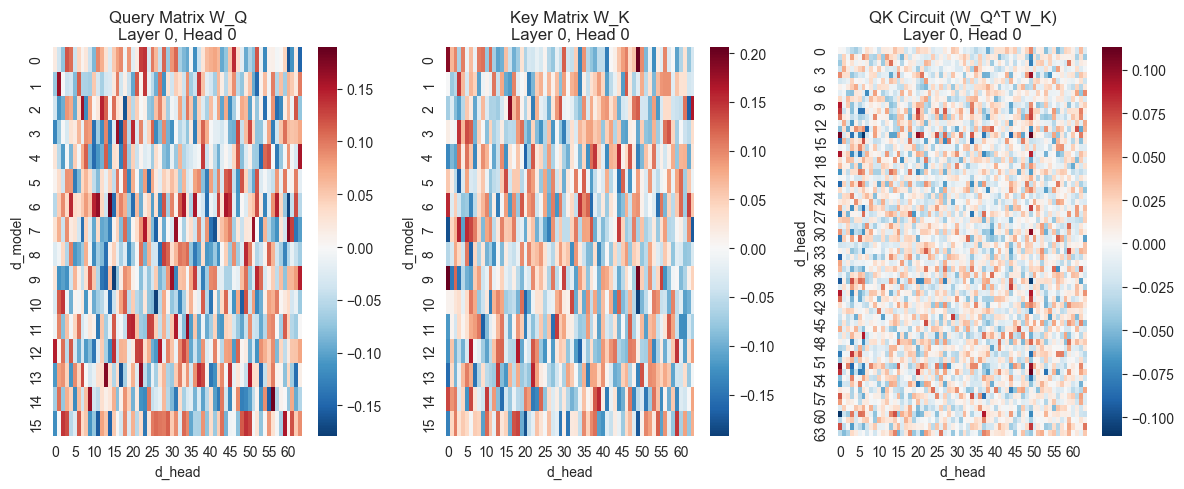

Layer 0, Head 1


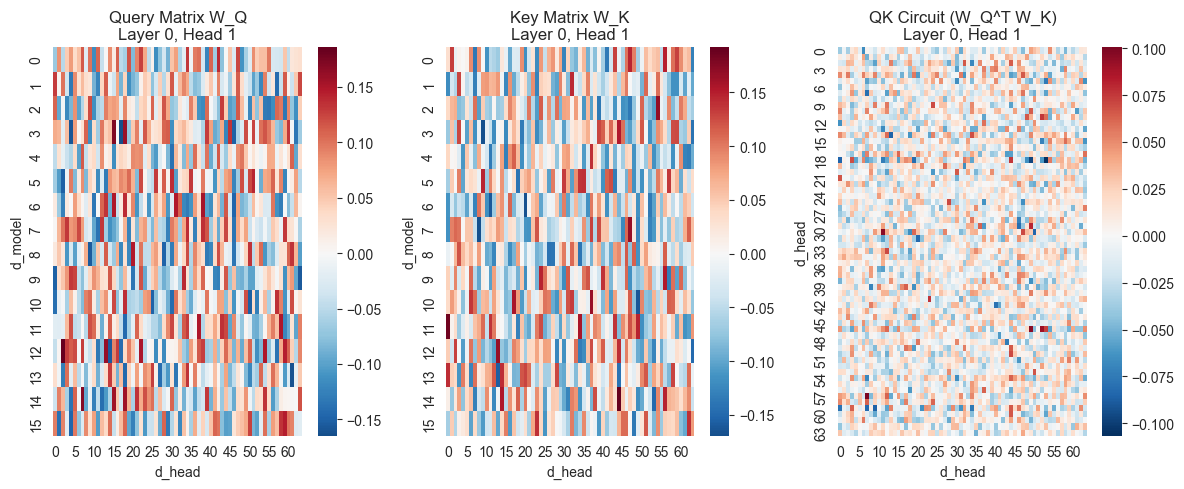

Layer 0, Head 2


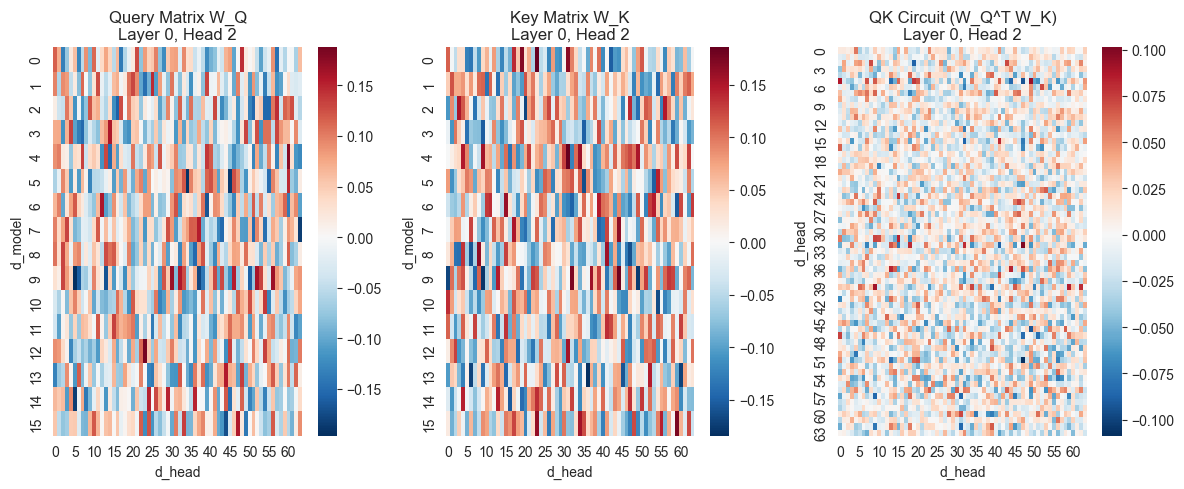

Layer 0, Head 3


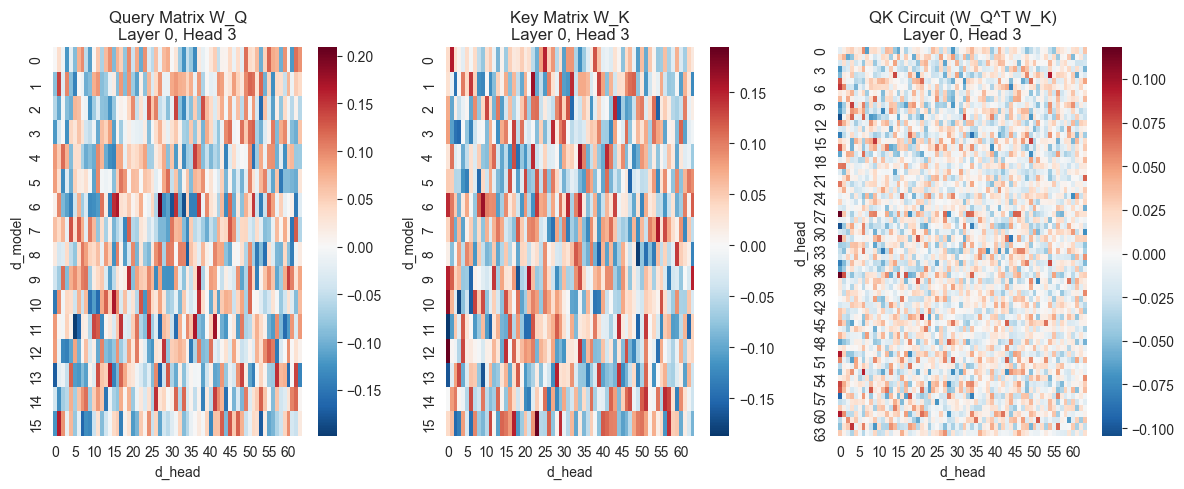

Layer 1, Head 0


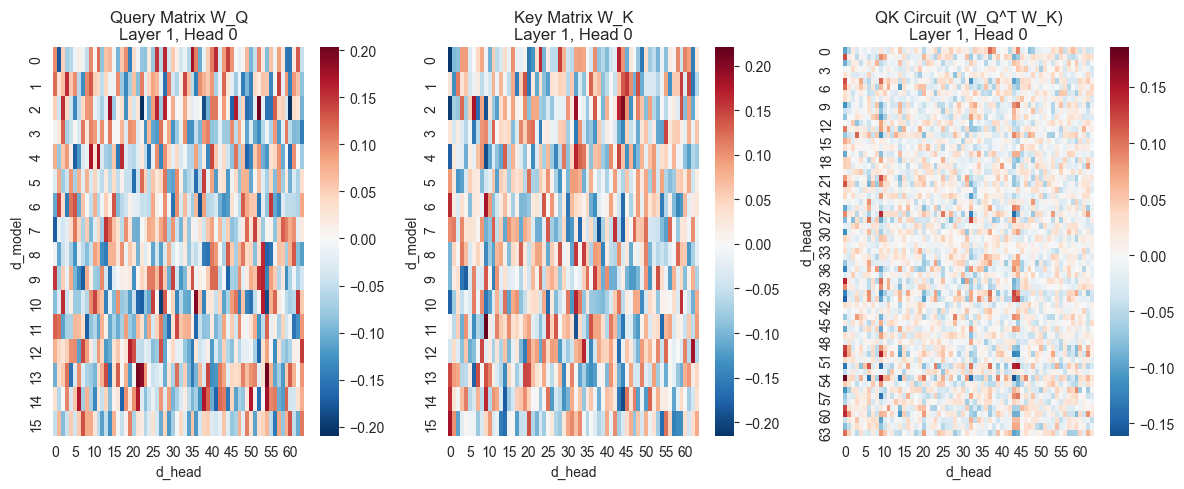

Layer 1, Head 1


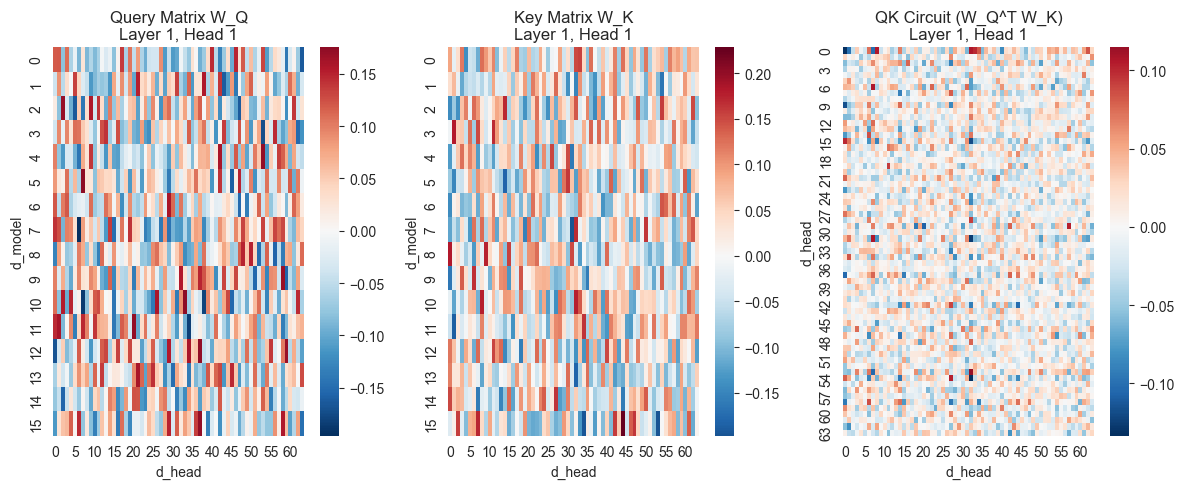

Layer 1, Head 2


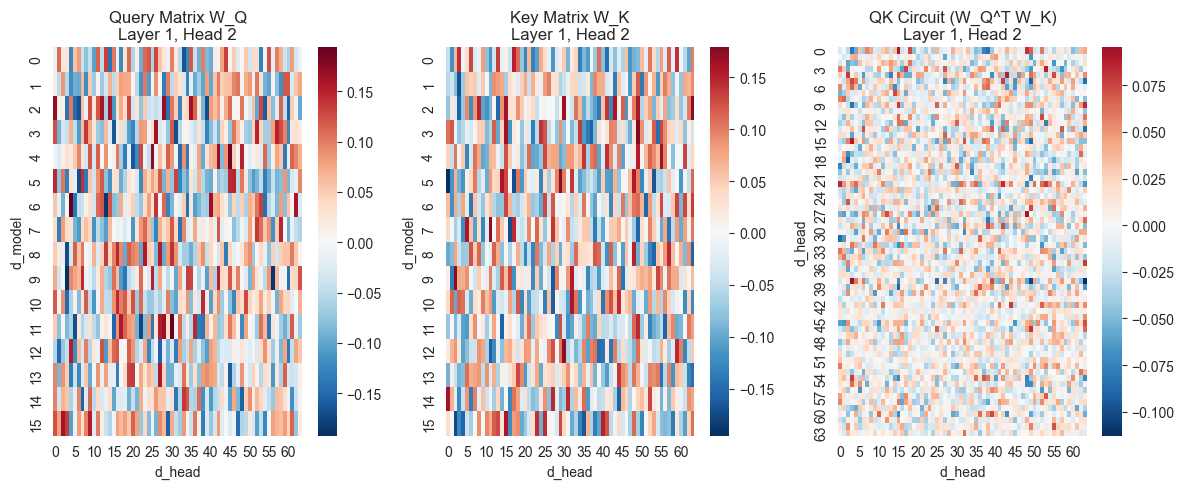

Layer 1, Head 3


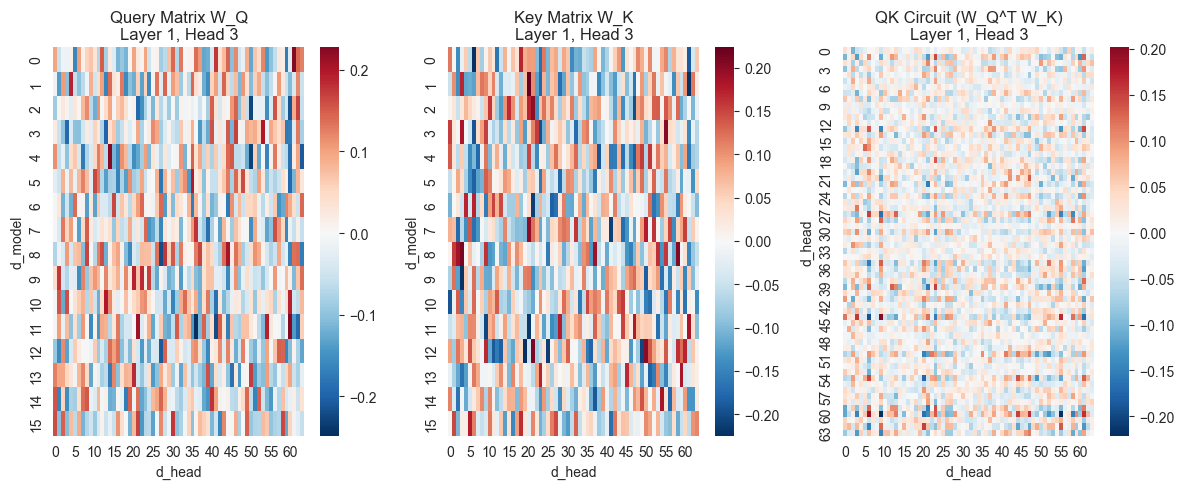


Interpretation:
- W_Q (Query): Determines what the token 'asks for'
- W_K (Key): Determines what the token 'advertises'
- QK Circuit: The composition determines attention patterns


In [ ]:
# Built with Claude Code, Nov 10 2025
# Visualize QK circuit for Layer 0, Head 0 (typically important)
print("Layer 0, Head 0")
fig = inspect_qk_circuit(model, layer_idx=0, head_idx=0)
plt.show()

print("Layer 0, Head 1")
fig = inspect_qk_circuit(model, layer_idx=0, head_idx=1)
plt.show()

print("Layer 0, Head 2")
fig = inspect_qk_circuit(model, layer_idx=0, head_idx=2)
plt.show()

print("Layer 0, Head 3")
fig = inspect_qk_circuit(model, layer_idx=0, head_idx=3)
plt.show()

print("Layer 1, Head 0")
fig = inspect_qk_circuit(model, layer_idx=1, head_idx=0)
plt.show()

print("Layer 1, Head 1")
fig = inspect_qk_circuit(model, layer_idx=1, head_idx=1)
plt.show()

print("Layer 1, Head 2")
fig = inspect_qk_circuit(model, layer_idx=1, head_idx=2)
plt.show()

print("Layer 1, Head 3")
fig = inspect_qk_circuit(model, layer_idx=1, head_idx=3)
plt.show()

print("\nInterpretation:")
print("- W_Q (Query): Determines what the token 'asks for'")
print("- W_K (Key): Determines what the token 'advertises'")
print("- QK Circuit: The composition determines attention patterns")

Honestly, I don't really see anything meaningful in these plots, so I'm just gonna default to looking at the previous 2x2 matrices where you could tell through a bunch of different cases how it's responding to different numbers.

# 7. Explanation

Based on my analysis of these attention mechanisms, I believe that the 0th layer has two heads that are specialized in capturing and passing through the bigger or the smaller number when that number is dramatically larger or smaller than the opposite one. Also, in that 0th layer are two other heads that are trying to capture information about when the two numbers are close to each other, where one is more focused on the larger number and one is more focused on the smaller number, but it is not clearly dominant.  The output of those attention hands are largely independent of which token is doing the attending, and almost entirely dependent on which tokens are being attended to.

The first layer then has two heads that are capturing information that's already been provided by earlier layers by just dominating to whatever the larger or the smaller number is that's provided. And then it also has two other heads that are actually doing a mixture of the information from the two tokens that are being attended to, and this calculation is actually conditional on which token is doing the attending. This seems like it's doing the real comparison in cases where the numbers are close together.

As an overall system, it appears that this network takes quick wins when, in the first layer, it can capture a very big or a very small number and declare victory about which one is larger or smaller. And then, when it's similar, it will pass that information forward to the second layer, which will do a more granular comparison with its conditional attention mechanism.

# 8. Reflection

I thought it was really interesting to learn how the attention mechanism plays out, in terms of, once it's trained, what features it looks for. It was very tricky to ascribe absolute function to any particular head or layer, because none of this is perfectly consistent. There was never a situation where every single case that it faced responded in the exact same way. It got close in some times where all but one cases were treated the same way, but nothing was absolute.  This seems to suggest that there is no clear basis that is perfectly aligned with any particular head, and in fact, it is the mixture of the heads that allows information to be encoded. Therefore, assuming that any particular neuron or head or layer is perfectly mapped to some concept that we as humans use to understand what's going on is unfounded.

It was pretty tricky to interpret and ascribe function, but it took a little bit of hand-waving in order to get a good enough answer, but ultimately I guess the point of interpretability is not to know with absolute certainty but to get a rough approximation, a simplification of what's going on that's good enough to build an intuition, and for that I was able to accomplish that.

I wish that the Transformers could explain to me what it's thinking about, what it's looking for in each of these, but maybe we need to build a new AI agent that looks through the attention head values and specializes in trying to tease that out and draw out insights into ways that we can comprehend.